In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2

import numpy as np

import sys
sys.path.append('../')

In [2]:
from depth_Functions import (
    import_raw_colour_image, 
    show_img, 
    show_array_of_images
)

In [3]:
from Feature_Extraction import (
    process_patches, 
    create_local_feature_vector
)

# Theory

In accordance with [3-D Depth Reconstruction from a Single Still Image](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf) determining the depth of a patch is better defined using information of it's suroundings

## Factors:

### Neighbour comparison

To features of adjacent patches are considered in calcualting the depth of a patch

### Scale:

How the features of a patch changes with scale can indicate it's properties i.e. differentiate grass from sky

### Column comparison

Assuming the image is of the real world, or at least a representation that mimics it, it is possible to use known common characteritics as part of our analysis

In the real world we know that structures do not float and therefore  information can be contained in the vertical column the patch lies in

## Our implementation

To utilise these factors we add multiply our feature vector to contain:
1. The features in the adjacent patches
1. The features of the patch and neighbouring patchs at increased scales
1. The features of the columns

We define:

|||
|-|-|
|Neighbours|Adjacent patches|
|Scales| $\times 1, \times 2, \times 3 $ |
|Columns|4 columns from top to bottom of the image|

In total the global feature vector has a length of $19\times34$: 

$$length =646$$

# Implementation

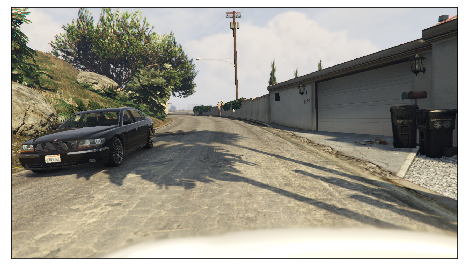

In [4]:
bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')
show_img(bgr)

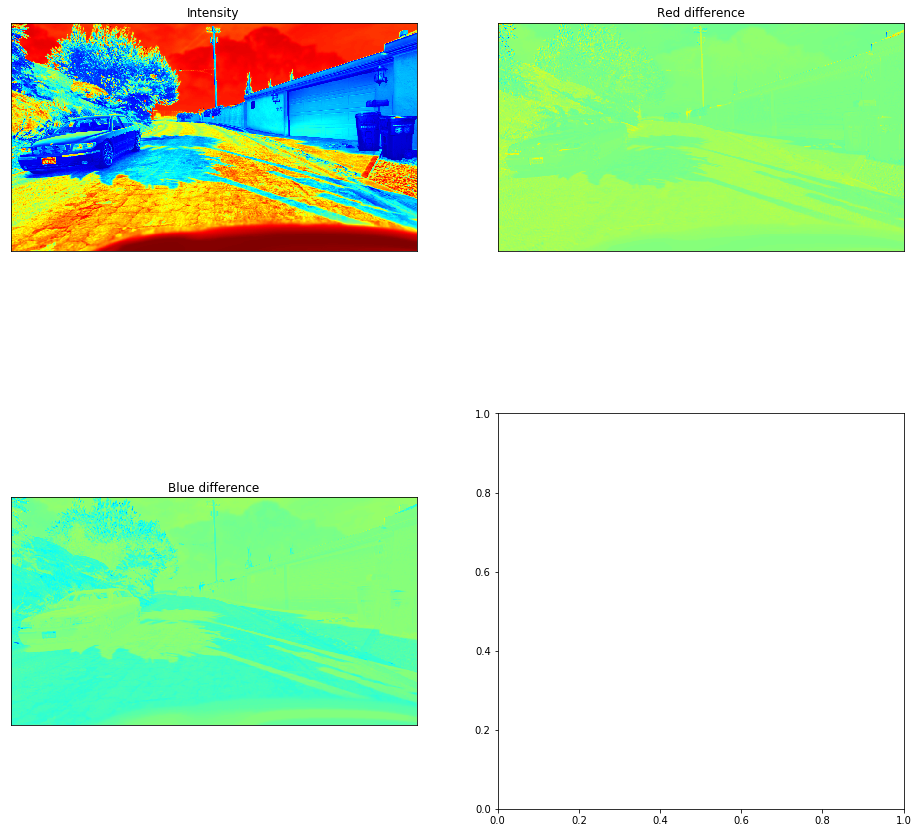

In [5]:
ycc = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb) 

show_array_of_images([ycc[:,:,i] for i in range(3)], shape=(2,2), heatmap=True,
                     titles=['Intensity', 'Red difference', 'Blue difference'])

## Neighbouring patches

We create our patches, the neighbour feature vectors are set to the patches vector

**n.b.** this means edge/corner patches will have their own feature vector recorded as unavailable patches.

e.g. Top left will record left and above neighbour as it's own feature vector

In [6]:
def create_global_feature_vector(patch):
    local_feature_vector = create_local_feature_vector(patch)
    return [local_feature_vector for i in range(5)]

In [7]:
patchsize = (24,24)

In [8]:
features = process_patches(ycc, patchsize=patchsize, function=create_global_feature_vector)

In [9]:
features.shape

(720, 1280, 5, 34)

set neighbour vector to (self, above, right, below, left)

**n.b. set_adjacent_features changes the existing array**

In [12]:
def set_adjacent_features(patches):
    heights = [y for y in range(0, patches.shape[0]+1, int(patches.shape[0]/2))]
    widths = [x for x in range(0, patches.shape[1]+1, int(patches.shape[1]/2))]
    
    for y in range(0,2):
        for x in range(0,2):
            patches[heights[y]:heights[y+1], 
                    widths[x]:widths[x+1], 3-(2*y)]   = patches[heights[1-y]:heights[2-y], 
                                                            widths[x]:widths[x+1], 0]
            patches[heights[y]:heights[y+1], 
                    widths[x]:widths[x+1], 2*(x+1)]   = patches[heights[y]:heights[y+1], 
                                                              widths[1-x]:widths[2-x], 0]
    

In [40]:
def get_features_with_neighbours(image, patchsize):
    features = process_patches(image, patchsize, function=create_global_feature_vector)
    process_patches(features, patchsize=(2*patchsize[0], 2*patchsize[1]), 
                    override=True, function=set_adjacent_features)
    
    return features

In [41]:
features_with_neighbours = get_features_with_neighbours(ycc, patchsize=(24,24))

In [42]:
features_with_neighbours.shape

(720, 1280, 5, 34)

In [44]:
features_with_neighbours[0][0][0] == features_with_neighbours[0][0][2]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [45]:
features_with_neighbours[0][0][2] == features_with_neighbours[0][24][0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

### Scale Patching

The patch is scaled up twice, each time the center and adjacent subpatches are calculated

In [75]:
def process_at_scales(patch, scales, function):
    for scale in scales:
        scaled_image = cv2.resize(patch, dsize=(patch.shape[1]*scale, patch.shape[0]*scale))
        function(scaled_image)

In [76]:
process_at_scales(bgr, [1,2,3], lambda image: print(image.shape))

(720, 1280, 3)
(1440, 2560, 3)
(2160, 3840, 3)


At larger scales 'neighbouring' subpatches are all contained within the same patch. As such there is no overlap of neighbours and they must be processed for each patch

In [ ]:
def subpatch_features(patch, patchsize):
    features = [create_global_feature_vector(patch[patchsize[0]:2*patchsize[0], 
                                                   patchsize[1]:2*patchsize[1]])]
    # Use process_patches with order
    